In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy.integrate import quad
from scipy.special import eval_laguerre
import itertools
import copy
from image_matrix_helper import compute_master_list, imshow_list, rgb_map, color_to_rgb, list_to_matrix
import random
import time

nb_start = time.time()

## Simulation for the Derangement Model 

In this notebook, we simulate a thermal system of particles of various colors binding onto a grid. We have $R$ different types of particles and particle of type $j$ has $n_j$ copies in the system. For the derangement model, particles can only exist \textit{on} thhe grid. Each particle type has a collection of "correct" locations on the grid. A particle of type $j$ attaches to this correct location with a Boltzmann factor of $\delta_j$. Here we want to use simulations of this system to affirm analytical calculations of the average number of correctly bound particles as functions of temperature. 

### Numerical representations of analytical work

#### System Partition Function 

The partition function for the system is 
\begin{equation}
Z_{\boldsymbol{n}}(\{\beta\Delta_k\})  = \int^{\infty}_{0} dx\, e^{-x} \, \prod_{k=1}^{R}\left(e^{\beta \Delta_k}-1\right)^{n_k}\, L_{n_k} \left( \frac{x}{1-e^{\beta\Delta_k}} \right).
\label{eq:znr}
\end{equation}

In [2]:
# delta function definition
delta_func = lambda Del, T: np.exp(Del/T)

In [3]:
# parameters for the model going forward
np.random.seed(42)
Dels0 = np.random.randn(10)+2 # randomly generated delta from normal distribution
Nelems0 = np.random.randint(1,10,10) # randomly generated integers 

In [4]:
## integrand of partition function
integrand = lambda x, deltas, ms: np.exp(-x)*np.prod([eval_laguerre(m, x/(1-delta))*(1-delta**(-1))**m for m, delta in zip(ms, deltas)])

# test function 
integrand(.40, np.exp(Dels0), Nelems0)

0.03200812850398603

In [5]:
## partition function for 
ZN_betalambda = lambda deltas, ms: quad(integrand, args =  (deltas, ms), a= 0,b =np.inf)[0]
error_ZN  = lambda deltas, ms: quad(integrand, args =  (deltas, ms), a= 0,b =np.inf)[1] 

# test function
ZN_betalambda(np.exp(Dels0), Nelems0)

189563.4375182251

#### Calculating $\langle m \rangle$ exactly

From this partitition function, we can calculate the average number of elements in their correct placement through the equation

\begin{equation}
\langle m \rangle  = \sum_{j=1}^{R} n_{j} e^{\beta \Delta_j} \frac{Z_{\boldsymbol{n}_{j}}(\{\beta\Delta_k\}) }{Z_{\boldsymbol{n}}(\{\beta\Delta_k\})},
\label{eq:ord_zn}
\end{equation}

where $\boldsymbol{n}_{j}$ is $\boldsymbol{n}$ with 1 subtracted from the $j$th component: $\boldsymbol{n}_{j}= (n_1, \ldots, n_{j}-1, \ldots, n_R)$. 

In [6]:
# function to get n_j
mj_vals = lambda j, ms: np.array([ms[k] if k != j else ms[k]-1 for k in range(len(ms))])

num = 3
# test function
print('original n vector:', Nelems0)
print(f'(n vector)_j value for j={num}:', mj_vals(num, Nelems0))

original n vector: [5 1 6 9 1 3 7 4 9 3]
(n vector)_j value for j=3: [5 1 6 8 1 3 7 4 9 3]


In [7]:
# average of ell
avg_m_exact = lambda T, Dels, ms: np.sum([ms[j]*ZN_betalambda(delta_func(Dels, T), mj_vals(j, ms))/ZN_betalambda(delta_func(Dels, T), ms) for j in range(len(ms))])

In [8]:
# testing evaluation
avg_m_exact(1.0, Dels0, Nelems0)

32.24972879913478

#### Thermal limits of disorder

At what temperature, will all the particles in the system settle into their correct location? In other words, with $\langle m \rangle$ representing the number of elements in their correct location, at what temperature does the system settle into the microstate  $\langle m \rangle = N$?"

In the accompanying paper, we found that this temperature $\beta_c = 1/k_BT_c$ is defined implicitly by 

$$ 1 = \sum_{j=1}^R n_j e^{-\beta_c\Delta_j}$$ 


We also found the necessary (but not sufficient) condition for the system to settle into the correct macrostate is 

$$ k_BT_c \leq \frac{1}{\ln N} \sum_{j=1}^r \frac{n_j}{N} \Delta_j$$

In [9]:
# implicit thermal constraint

def therm_constr(beta,Dels, Ns):
    
    F =  1-np.sum(Ns*np.exp(-Dels*beta))
    
    return F

# critical temperature
kBTcrit = lambda Dels, Ns: 1.0/fsolve(therm_constr, x0 = 0.5, args = (Dels, Ns))[0]


# Test function 
kBTcrit(Dels0, Nelems0)

0.561392354979486

In [10]:
# necessary condition for temperature
kBTlimit = lambda Dels, Ns : 1.0/(np.sum(Ns)*np.log(np.sum(Ns)))*np.sum(Dels*Ns)

# Test function 
kBTlimit(Dels0, Nelems0)

0.6809298387017404

In [11]:
# checking inequality
kBTcrit(Dels0, Nelems0) < kBTlimit(Dels0, Nelems0)

True

#### Large Temperature Limit

We found that in the limit of large temperature the total number of correctly ordered components has the behavior

$$ \lim_{T \to \infty} \langle m\rangle  = \dfrac{ \sum_{j=1}^R n_j^2}{ \sum_{j=1}^R n_j}.$$

In [12]:
## ell limit
m_limit = lambda Ns : np.sum(Ns*Ns)/np.sum(Ns)

#### Equations of Large $N$ approximation 

The order parameter for this system can be approximated as 
\begin{align}
\langle m\rangle & =   \sum_{j=1}^R \frac{n_j }{1- \delta_j^{-1}} \frac{\displaystyle L_{n_j-1} \left( \bar{\sigma}_{j}\right)}{\displaystyle  L_{n_j} \left( \bar{\sigma}_{j} \right)},
\label{eq:jtox}
\end{align}
where $\bar{x}$ is defined from 
\begin{equation}
N- \bar{x} = \sum_{j=1}^{R} n_j \frac{\displaystyle L_{n_j-1} \left( \bar{\sigma}_{j}\right)}{\displaystyle  L_{n_j} \left( \bar{\sigma}_{j} \right)}
\label{eq:barx}
\end{equation}
with $\bar{\sigma}_{j} \equiv{\bar{x}}/(1-\delta_j); \delta_j = e^{\Delta_j/T}$ for notational simplicity  

In [13]:
# function that determines xbar
def xbar_func(x, T, Dels, Ns):
    
    R = len(Ns)
    deltas_ = delta_func(Dels, T)
    sigmas_ = x/(1-deltas_)
    
    RHS = np.sum([Ns[j]*eval_laguerre(Ns[j]-1, sigmas_[j])/eval_laguerre(Ns[j], sigmas_[j]) for j in range(R)])
    
    LHS = np.sum(Ns) -x
    
    return LHS-RHS

# function that determs ellavge for large N
def avg_m_approx(T, Dels, Ns):
    
    R = len(Ns)
    xbar = fsolve(xbar_func, x0 = np.sum(Ns), args = (T, Dels, Ns))
    deltas_ = delta_func(Dels, T)
    sigma_bars = xbar/(1-deltas_)
    
    return np.sum([Ns[j]*deltas_[j]/(deltas_[j]-1)*eval_laguerre(Ns[j]-1, sigma_bars[j])/eval_laguerre(Ns[j], sigma_bars[j]) for j in range(R)] )

#### Example analytical plot

In [14]:
# temperature vals
Tvals = np.linspace(0.1, 3.0, 50)

# parameters for the integral
np.random.seed(42)
Dels0 = np.random.randn(10)+2
n_vals = np.random.randint(1,10,10) # randomly generated integers 

# computed averages for each temperature
avg_m_exact_vals = np.array([avg_m_exact(T, Dels0, Nelems0) for T in Tvals])
avg_m_approx_vals = np.array([avg_m_approx(T, Dels0, Nelems0) for T in Tvals])

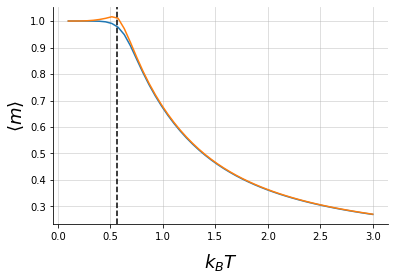

In [15]:
## plotting order parameters
ax = plt.subplot(111)
ax.plot(Tvals, avg_m_exact_vals/np.sum(Nelems0), label = 'Exact')
ax.plot(Tvals, avg_m_approx_vals/np.sum(Nelems0), label = 'Large N')
ax.set_ylabel(r'$\langle m \rangle$', fontsize = 18)
ax.set_xlabel(r'$k_BT$', fontsize = 18, labelpad = 10.5)
ax.grid(alpha = 0.5)
ax.axvline(x = kBTcrit(Dels0, Nelems0), color = 'k', linestyle = '--')
# ax.set_ylim([0,50])
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

### Metropolis Hastings simulation code 

#### Microstate transitions

In [16]:
## permutation operator
def perm(init_ls):
    Ncomp = len(init_ls)
    i1 = int(random.choice(range(Ncomp)))
    i2 = int(random.choice(range(Ncomp)))

    ## new omega vector 
    fin_ls = copy.deepcopy(init_ls)
    fin_ls[i2] = init_ls[i1]
    fin_ls[i1] = init_ls[i2]
    
    return(fin_ls)

#### Function to count the number of correct elements in a bound vector

In [17]:
## number of correctly placed elements
def m_calc(vec, mstr_vec):
    
    num = 0
    
    for k in range(len(mstr_vec)):
        if mstr_vec[k] == vec[k]:
            num += 1
    
    return num

#### Logarithm of Botlzmann factor

The logarithm of the Botlzmann factor for a microstate (i.e., the temperature normalized negative energy of the microstate) is defined as 

\begin{equation}
\beta E(\boldsymbol{m}) = \sum_{i=1}^R m_i \ln \delta_i.
\label{eq:sim_en}
\end{equation}

In [18]:
# log of boltzmann factor
def log_boltz(bound_objs, mstr_vec, deltas, name_key):
    
    corr_log_factor = 0
    for j in range(len(bound_objs)):
        if bound_objs[j] == mstr_vec[j]:
            elem = bound_objs[j]
            key = name_key[elem]
            corr_log_factor+=np.log(deltas[key])        
    
    return corr_log_factor    

#### Checking logarithm of Boltzmann factor definition

In [19]:
# defining name key
name_key0 = dict()
key_list = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', ]
for j in range(len(key_list)):
    name_key0[key_list[j]] = j
    
# random energies    
np.random.seed(2)
q1 = np.random.rand(10)

# sample master list
sample_master = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', ]

print('Energy for original ordering:', log_boltz(sample_master, sample_master, np.exp(-q1), name_key0))
print('Checking energy value:', -np.sum(q1))
print('Number of correctly placed elements:', m_calc(sample_master, sample_master))
print('-----')
changed_list = perm(sample_master)
print('Energy after switching first and last values:', log_boltz(changed_list, sample_master, np.exp(-q1), name_key0))
print('Checking energy value:', -np.sum(q1*(np.array(changed_list)==np.array(sample_master))))
print('Number of correctly placed elements:', m_calc(changed_list, sample_master))

Energy for original ordering: -3.58801017672414
Checking energy value: -3.58801017672414
Number of correctly placed elements: 10
-----
Energy after switching first and last values: -3.58801017672414
Checking energy value: -3.58801017672414
Number of correctly placed elements: 10


#### Metropolis Hastings algorithm

In [20]:
### Metropolis Monte Carlo Algorithm 

## loads uniform random sampling 
runif = np.random.rand

def met_gen_derang(Niter, bound_objs, mstr_vec, deltas, name_key):
    '''
    #################################################################
    # function to sample using Metropolis 
    #  
    # n_iter:  number of iterations
    # initial_state: initial state for the start position for our chain
    # gamma: energy cost for incorrect component
    # temp: temperature 
    ##################################################################
    '''
    # Initialize trace for state values
    state_vals = [0]*(Niter+1)
    
    # Set initial values
    state_vals[0] = bound_objs
        
    # Initialize acceptance counts
    # We can use this to tune our step size
    accepted = 0
    
    for i in range(Niter):
    
        # get current permutation
        current_bound_objs = state_vals[i]
        
        # proposed new permutation; generated from random integer sampling
        new_bound_objs = perm(current_bound_objs)
        
        #sets current log-probability
        log_current_prob = log_boltz(current_bound_objs, mstr_vec, deltas, name_key)
                
        # Calculate posterior log-probability with proposed value
        log_proposed_prob = log_boltz(new_bound_objs, mstr_vec, deltas, name_key)

        # Log-acceptance rate
        log_alpha = log_proposed_prob- log_current_prob

        # Sample a uniform random variate
        u = runif()

        # Test proposed value
        if np.log(u) <= log_alpha:
            # Accept
            state_vals[i+1] = new_bound_objs
            log_current_prob = log_proposed_prob
            accepted += 1
        else:
            # Stay put
            state_vals[i+1] = state_vals[i]

    # return our samples and the number of accepted steps
    return state_vals, accepted

#### Computing microstate average from simiulations

In [21]:
def avg_m(state_vals, mstr_vec, n_mc):
    
    """
    Microstate average of number of correctly bound objects
    We only consider microstates near the end of theh chain to ensure
    that the system has equilibrated
    """     
    
    length = int(n_mc/50)
    
    ls = [0]*length
    ls = np.array(ls)
    for k in range(length):
        ls[k] = m_calc(state_vals[n_mc-length+k], mstr_vec)
    
    
    return(np.mean(ls))

#### Image grid for completely correct configuration

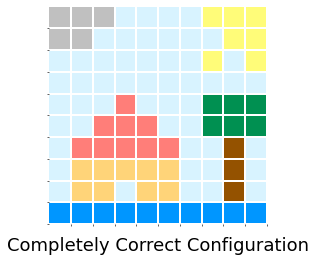

In [22]:
# defining master_list
master_list =compute_master_list()
# testing plot
imshow_list(master_list, title = 'Completely Correct Configuration');
# defining Nelems
Nelems = np.zeros(8)
key_list = list(rgb_map.keys())[:-1]
name_key_ = dict()
for j in range(len(key_list)):
    name_key_[key_list[j]] = j
    Nelems[j] = master_list.count(key_list[j])

In [23]:
# displaying copy-number counts of the various elements
Nelems

array([ 9.,  9., 10.,  5.,  7.,  6.,  3., 51.])

#### Simulating system

In [24]:
## Generate lf for each temperature from .03 to 2.0 in npoints steps
t0 = time.time()

# number of steps for MC algortihm
Nmc = 20000

# binding energy parameters
R = 8
Del_bar, sigma_D = 4.0, 2.0
Dels = np.random.randn(R)*sigma_D+Del_bar
    
random.seed(0)

# initial monomer and dimer states; 
# system in microstate of all correct dimers
bound_objs_0 = random.sample(master_list, len(master_list))
mstr_vec = copy.deepcopy(master_list)

# temperature limits
Tmin = .05
Tmax = 3.05

npoints = 15 #number of temperature values
navg = 5 # number of times we run simulation at each temperature; 50 in paper
temp_vals = np.linspace(Tmin, Tmax, npoints).tolist()

# list of dimer values 
sim_m_vals = [0]*npoints

# accepted list 
accepted_list = [0]*npoints

# saved list for plotting
saved_list = dict()

for k in range(npoints):

    final_m_vals = [0]*navg

    for j in range(navg):
        
        # make copy of initial monomer and dimer states 
        bound_objs_copy = copy.deepcopy(bound_objs_0)        
        
        # defining helper functions
        deltas_ = delta_func(Dels, temp_vals[k])        

        # make copy of list 
        master_list_copy = copy.deepcopy(master_list)

        # metroplois generator
        bound_list, accepted = met_gen_derang(Nmc, bound_objs_copy, mstr_vec, deltas_, name_key_)

        # calculate final j value
        final_m_vals[j] = avg_m(bound_list, master_list, Nmc)

    # saving averaged values        
    sim_m_vals[k] = np.mean(np.array(final_m_vals))

    if (k+1)%5 ==0 or k ==0:
        saved_list[k] = ['white' if x=='-' else x for x in bound_list[-1]]          

    time_prelim = time.time()
    print("Temperature Run:",str(k+1),"; Current Time:", round(time_prelim-t0,2),"secs")

t1 = time.time()
print("Total simulation run time: %secs" % (t1-t0))
print("------")
print()

Temperature Run: 1 ; Current Time: 49.38 secs
Temperature Run: 2 ; Current Time: 96.82 secs
Temperature Run: 3 ; Current Time: 144.21 secs
Temperature Run: 4 ; Current Time: 187.47 secs
Temperature Run: 5 ; Current Time: 226.98 secs
Temperature Run: 6 ; Current Time: 263.06 secs
Temperature Run: 7 ; Current Time: 299.26 secs
Temperature Run: 8 ; Current Time: 335.83 secs
Temperature Run: 9 ; Current Time: 372.2 secs
Temperature Run: 10 ; Current Time: 405.93 secs
Temperature Run: 11 ; Current Time: 441.39 secs
Temperature Run: 12 ; Current Time: 473.89 secs
Temperature Run: 13 ; Current Time: 503.44 secs
Temperature Run: 14 ; Current Time: 533.46 secs
Temperature Run: 15 ; Current Time: 560.87 secs
Total simulation run time: 560.8682470321655ecs
------



#### Simulated image grid at various temperatures

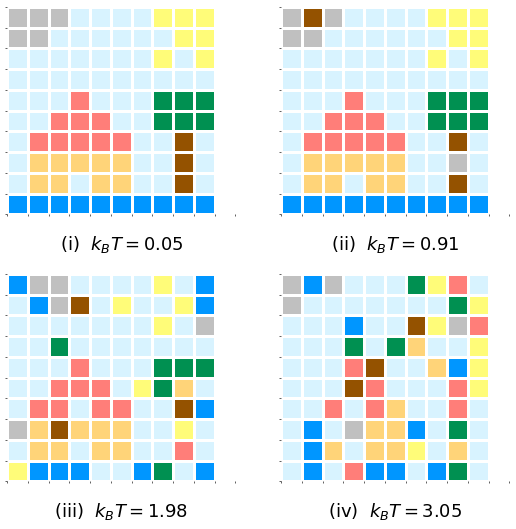

In [25]:
# figure parameters
rows, cols, idx = 2, 2, 0
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(9,9))

# list of keys for saved snapshots of image
img_key_list = list(saved_list.keys())

for i in range(rows):
    for j in range(cols):
        if idx < 4:
            axes[i, j].imshow(color_to_rgb(list_to_matrix(saved_list[img_key_list[idx]])))
            ax = plt.gca()
            
            # making ticks invisible
            axes[i, j].set_xticks([])
            axes[i, j].set_yticks([])

            # Minor ticks
            axes[i, j].set_xticks(np.arange(-0.5, 11, 1), minor=True)
            axes[i, j].set_yticks(np.arange(-0.5, 10, 1), minor=True)
            axes[i, j].tick_params(axis='y', colors='red')
            
            # labeling images
            itimes = 'i'*(1+idx) if idx<3 else 'iv'
            
            # Gridlines based on minor ticks
            axes[i, j].grid(which='minor', color='w', linestyle='-', linewidth=3)
            axes[i, j].set_title(fr'({itimes})  $k_BT = {round(temp_vals[img_key_list[idx]],2)}$', fontsize = 18, y = -.2)

            # making spines invisible
            axes[i, j].spines['right'].set_visible(False)
            axes[i, j].spines['top'].set_visible(False)
            axes[i, j].spines['left'].set_visible(False)
            axes[i, j].spines['bottom'].set_visible(False)  
            
            idx +=1

# plt.savefig('derang_grid_assembly_grid_plots.png', bbox_inches='tight', format = 'png')    
plt.show()

#### Comparing analytical and simulation results

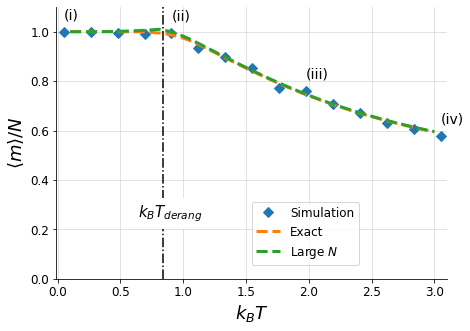

In [26]:
plt.figure(figsize = (7,5))
ax = plt.subplot(111)

# plot of simulation results
plt.plot(temp_vals,sim_m_vals/np.sum(Nelems), 
        label = f'Simulation',
        markersize = 7.5,
       marker = 'D',
       linestyle = '')

# plot of exact analytical results 
m_exact_vals = [avg_m_exact(T, Dels, Nelems) for T in Tvals]
plt.plot(Tvals, m_exact_vals/np.sum(Nelems),linestyle = '--', linewidth = 3.0, label = f'Exact')     

# plot of large N analytical results
m_largeN_vals = [avg_m_approx(T, Dels, Nelems) for T in Tvals]
plt.plot(Tvals, m_largeN_vals/np.sum(Nelems),linestyle = '--', linewidth = 3.0, label = f'Large $N$')     

# plot of critical temperature 
plt.axvline(x = kBTcrit(Dels, Nelems), color = 'k',  linestyle = '-.')   

plt.legend(loc = (.5,0.05), fontsize = 12)
# plot formatting
ax.set_xlabel(r'$k_B T$', fontsize = 18)
plt.xlim([-0.01,3.1])
plt.ylim([0,1.1])
plt.ylabel(r'$\langle m \rangle/N$', fontsize = 18)
# plt.yaxis.set_label_coords(-0.1,.5)
plt.grid(alpha = 0.45)


# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

# increase label size
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=12)

ax.text(kBTcrit(Dels, Nelems)-.2, 0.25, r'$k_BT_{derang}$', color='black', fontsize = 15,
        bbox=dict(facecolor='white', edgecolor='none', pad=5.0))

for i in range(4):
    ax.text(temp_vals[img_key_list[i]], sim_m_vals[img_key_list[i]]/np.sum(Nelems)+.05,'('+'i'*(1+i)+')' if i<3 else '(iv)', fontsize = 14 )

# plt.savefig(f'derang_model.png', bbox_inches='tight', format = 'png')    
plt.show()

In [27]:
print('Total Notebook Runtime: %.3f mins' % ((time.time()-nb_start)/60))

Total Notebook Runtime: 9.734 mins
